In [3]:
from tifffile import imread
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
DATA = Path.home() /"Desktop/Code/CELLSEG_BENCHMARK/TPH2_mesospim/TRAINING"

In [5]:
training_files = list(DATA.glob("*.tif"))
training_labels = list(DATA.glob("labels/*.tif"))
test_files = list(DATA.glob("visual/*.tif"))
test_labels = list(DATA.glob("labels/visual/*.tif"))

In [7]:
data_stats = pd.DataFrame(columns=["path_image", "path_label", "origin_volume", "label_count", "training_data"])

In [8]:
data_stats["path_image"] = [str(file) for file in training_files]
data_stats["path_label"] = [str(file) for file in training_labels]
data_stats["training_data"] = [True for file in training_files]
# append entries for test data
data_stats = pd.concat(
    [
        data_stats, 
        pd.DataFrame(
            columns=data_stats.columns, 
            data={
                "path_image": [str(file) for file in test_files],
                "path_label": [str(file) for file in test_labels],
                "training_data": [False for file in test_files]
                }
            )
        ]
    )

In [9]:
def _find_origin_volume(paths, volumes=["c1", "c2", "c3", "c4", "c5", "visual"]):
    """Find the origin volume of a given image path."""
    volumes = [
        "c1",
        "c2",
        "c3",
        "c4",
        "c5",
        "visual",
    ]
    return [volume for volume in volumes if volume in paths][0]

In [10]:
data_stats["origin_volume"] = data_stats["path_image"].apply(_find_origin_volume)
data_stats["name"] = data_stats["path_image"].apply(lambda x: Path(x).stem)

In [11]:
def _label_count(label_path):
    """Count the number of labels in a label image."""
    label = imread(label_path)
    return len(np.unique(label)) - 1

In [12]:
data_stats["label_count"] = data_stats["path_label"].apply(_label_count).astype(int)

In [13]:
# calculate percentage of labels for each volume
total_per_volume = data_stats.groupby("origin_volume")["label_count"].sum()

In [14]:
total_per_volume

origin_volume
c1         697
c2        1093
c3        1499
c4         720
c5         905
visual     972
Name: label_count, dtype: int32

In [15]:
def _find_unique_labels_in_volume(data_df):
    """Find unique labels per crop of origin volume"""
    volumes_unique_labels = {}
    for volumes in data_df.origin_volume.unique():
        uniques_volume = np.array([])
        for idx, row in data_df[data_df.origin_volume == volumes].iterrows():
            label = imread(row["path_label"])
            uniques_volume = np.concatenate((uniques_volume, np.unique(label)))
        volumes_unique_labels[volumes] = len(np.unique(uniques_volume).flatten()) - 1
    return volumes_unique_labels

In [16]:
labels_uniques = _find_unique_labels_in_volume(data_stats)
labels_uniques = pd.DataFrame.from_dict(labels_uniques, orient="index", columns=["unique_labels"])
labels_uniques["percentage"] = labels_uniques["unique_labels"] / labels_uniques["unique_labels"].sum()
labels_uniques["training_data"] = [i != "visual" for i in labels_uniques.index] 

In [17]:
labels_uniques

,unique_labels,percentage,training_data
c1,343,0.130319,True
c2,365,0.138678,True
c3,631,0.239742,True
c4,396,0.150456,True
c5,347,0.131839,True
visual,550,0.208967,False


In [18]:
labels_uniques.sum()

unique_labels    2632.0
percentage          1.0
training_data       5.0
dtype: float64

In [19]:
data_stats

,path_image,path_label,origin_volume,label_count,training_data,name
0,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c1,18,True,c1image_0_crop
1,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c1,112,True,c1image_10_crop
2,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c1,100,True,c1image_11_crop
3,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c1,5,True,c1image_1_crop
4,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c1,2,True,c1image_2_crop
...,...,...,...,...,...,...
19,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,visual,44,False,a_isotropic_visual_5_crop
20,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,visual,25,False,a_isotropic_visual_6_crop
21,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,visual,13,False,a_isotropic_visual_7_crop
22,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,visual,13,False,a_isotropic_visual_8_crop


In [20]:
data_stats.label_count.sum()

5886

<Axes: ylabel='Frequency'>

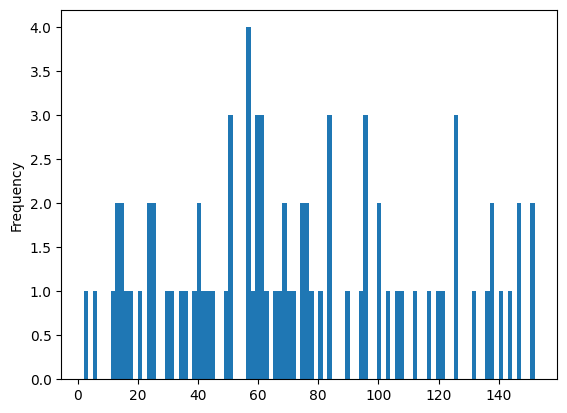

In [21]:
data_stats.label_count.plot(kind="hist", bins=100)

In [22]:
def _knapsack(items, max_weight):
    """Simple solver for the knapsack problem."""
    num_items = len(items)
    table = [[0 for _ in range(max_weight + 1)] for _ in range(num_items + 1)]

    # Convert the dictionary items to lists for easier indexing
    paths, weights = zip(*items.items())

    for i in range(num_items + 1):
        for w in range(max_weight + 1):
            if i == 0 or w == 0:
                table[i][w] = 0
            elif weights[i-1] <= w:
                table[i][w] = max(weights[i-1] + table[i-1][w-weights[i-1]], table[i-1][w])
            else:
                table[i][w] = table[i-1][w]

    selected_paths = []
    w = max_weight
    for i in range(num_items, 0, -1):
        if table[i][w] != table[i-1][w]:
            selected_paths.append(paths[i-1])
            w -= weights[i-1]

    return selected_paths

def select_volumes(data_stats, labels_unique, percentage, tolerance=0.5, verbose=True):
    """
    Selects the volumes that sum up to the desired percentage of the total cell count within the tolerance.
    
    Args:
        data_stats (pd.DataFrame): DataFrame with the data statistics.
        labels_unique (np.array): Unique labels per volume.
        percentage (float): Desired percentage of the total cell count.
        tolerance (float): Tolerance for the cell count.
        verbose (bool): Print the selected volumes and cell count.
    
    Returns:
        list: Selected volumes.
    """ 
    total_cell_count = labels_unique.sum().astype(int)
    desired_cell_count = np.floor(total_cell_count * percentage / 100).astype(int)
    cell_count_tolerance = np.floor(total_cell_count * tolerance / 100).astype(int)
    if verbose:
        print(f"Total cell count: {total_cell_count}")
        print(f"Desired cell count: {desired_cell_count}")
        print(f"Cell count tolerance: {cell_count_tolerance}")
    
    data_stats_sorted = data_stats.sort_values("label_count", ascending=False)

    # Create a dictionary where each key is a path and each value is the corresponding label count
    path_dict = data_stats_sorted.set_index("path_image")["label_count"].to_dict()

    # Find the most optimal combination of volumes that sum up to the desired cell count within the tolerance
    selected_volumes = _knapsack(path_dict, desired_cell_count)

    # If not found, scan within the tolerance
    if len(selected_volumes) == 0:
        print(f"No proper combination found. Trying within tolerance values. Consider increasing the tolerance value if occurs frequently.")
        tolerance_values = np.arange(desired_cell_count - cell_count_tolerance, desired_cell_count + cell_count_tolerance).astype(int)
        for cell_count_tolerance_value in tolerance_values:
            print(f"Trying with tolerance value: {cell_count_tolerance_value}")
            selected_volumes = _knapsack(path_dict, cell_count_tolerance_value)
            if len(selected_volumes) > 0:
                break
    if verbose:
        selected_cell_count = sum(path_dict[path] for path in selected_volumes)
        print(f"Selected {len(selected_volumes)} volumes with {selected_cell_count} cells.")

    return selected_volumes

In [23]:
training_data_stats = data_stats[data_stats.training_data]

In [24]:
selected_volumes = select_volumes(
    training_data_stats,
    training_data_stats.label_count,
    80
    )

Total cell count: 4914
Desired cell count: 3931
Cell count tolerance: 24
Selected 36 volumes with 3931 cells.


In [25]:
data_stats[data_stats["path_image"].isin(selected_volumes)].sort_values("label_count", ascending=False)

,path_image,path_label,origin_volume,label_count,training_data,name
30,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c3,152,True,c3image_15_crop
54,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c5,152,True,c5image_4_crop
49,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c4,146,True,c4image_7_crop
27,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c3,146,True,c3image_12_crop
41,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c3,144,True,c3image_9_crop
56,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c5,140,True,c5image_6_crop
11,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c1,138,True,c1image_9_crop
48,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c4,138,True,c4image_6_crop
46,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c4,136,True,c4image_4_crop
47,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...,c4,131,True,c4image_5_crop


In [26]:
splits = [10, 20, 40, 80]
for s in splits:
    print("_"*20)
    print(f"Splitting data : {s}%")
    selected_volumes = select_volumes(
        training_data_stats, 
        training_data_stats.label_count,
        s, 
        verbose=False
        )
    selected_count = data_stats[data_stats["path_image"].isin(selected_volumes)].label_count.sum()
    num_volumes = len(selected_volumes)
    total_volumes = len(training_data_stats)
    percentage = num_volumes / total_volumes * 100
    print(f"Selected {len(selected_volumes)}/{len(training_data_stats)} ({percentage:.2f}% of training data) volumes with {selected_count} cells.")

____________________
Splitting data : 10%
Selected 4/58 (6.90% of training data) volumes with 491 cells.
____________________
Splitting data : 20%
Selected 7/58 (12.07% of training data) volumes with 982 cells.
____________________
Splitting data : 40%
Selected 15/58 (25.86% of training data) volumes with 1965 cells.
____________________
Splitting data : 80%
Selected 36/58 (62.07% of training data) volumes with 3931 cells.


Text(0, 0.5, 'Percentage of volumes used')

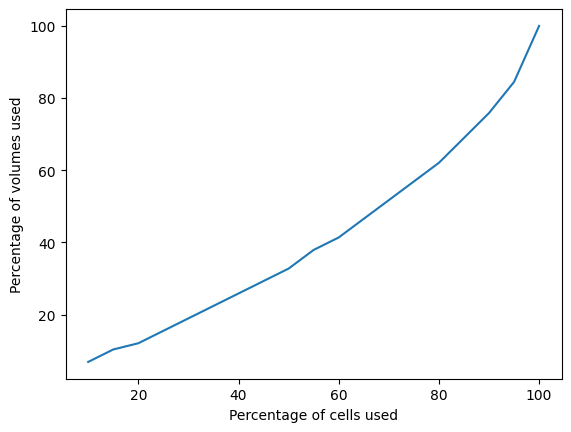

In [27]:
# plot evolution of % volumes used based on % cells used
splits = np.arange(10, 101, 5)
volume_percentage = []
for s in splits:
    selected_volumes = select_volumes(
        training_data_stats, 
        training_data_stats.label_count,
        s, 
        verbose=False
        )
    num_volumes = len(selected_volumes)
    total_volumes = len(training_data_stats)
    percentage = num_volumes / total_volumes * 100
    volume_percentage.append(percentage)
plt.plot(splits, volume_percentage)
plt.xlabel("Percentage of cells used")
plt.ylabel("Percentage of volumes used")

In [28]:
splits = np.arange(10, 101, 5)
percent_cells = []
for s in splits:
    print("_"*20)
    print(f"Splitting data : {s}%")
    selected_volumes = training_data_stats.sample(frac=s/100).path_image
    selected_count = data_stats[data_stats["path_image"].isin(selected_volumes)].label_count.sum()
    percent_cells.append(selected_count / training_data_stats.label_count.sum() * 100)
    num_volumes = len(selected_volumes)
    total_volumes = len(training_data_stats)
    percentage = num_volumes / total_volumes * 100
    print(f"Selected {len(selected_volumes)}/{len(training_data_stats)} ({percentage:.2f}% of training data) volumes with {selected_count} cells.")

____________________
Splitting data : 10%
Selected 6/58 (10.34% of training data) volumes with 615 cells.
____________________
Splitting data : 15%
Selected 9/58 (15.52% of training data) volumes with 704 cells.
____________________
Splitting data : 20%
Selected 12/58 (20.69% of training data) volumes with 1009 cells.
____________________
Splitting data : 25%
Selected 14/58 (24.14% of training data) volumes with 1280 cells.
____________________
Splitting data : 30%
Selected 17/58 (29.31% of training data) volumes with 1528 cells.
____________________
Splitting data : 35%
Selected 20/58 (34.48% of training data) volumes with 1590 cells.
____________________
Splitting data : 40%
Selected 23/58 (39.66% of training data) volumes with 2138 cells.
____________________
Splitting data : 45%
Selected 26/58 (44.83% of training data) volumes with 2419 cells.
____________________
Splitting data : 50%
Selected 29/58 (50.00% of training data) volumes with 2534 cells.
____________________
Splitting d

Text(0, 0.5, 'Percentage of cells used')

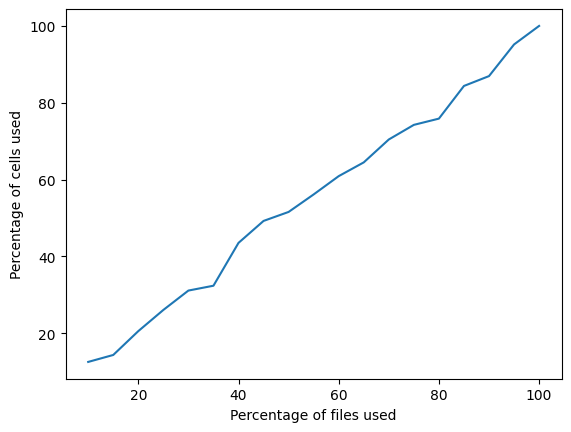

In [29]:
plt.plot(splits, percent_cells)
plt.xlabel("Percentage of files used")
plt.ylabel("Percentage of cells used")